# Data Analytics and Classification Model for Failure Detection of Wind Turbine from IIoT Data

In [3]:
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, classification_report
from lightgbm import LGBMClassifier

%config InlineBackend.figure_format = 'retina'

# 1. Read data

We have 3 data:

* `scada_data.csv`: Contains >60 information (or status) of wind turbine components recorded by SCADA system
* `fault_data.csv`: Contains wind turbine fault types (or modes)
* `status_data.csv`: Contains description of status of wind turbine operational

In [4]:
scada_df = pd.read_csv('./Wind_dataset/scada_data.csv')
scada_df['DateTime'] = pd.to_datetime(scada_df['DateTime'])
# scada_df.set_index('DateTime', inplace=True)

scada_df

,DateTime,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Rectifier cabinet temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
0,2014-05-01 00:00:00,1398920448,0,6.9,9.4,2.9,0.00,0.02,0.00,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
1,2014-05-01 00:09:00,1398920960,0,5.3,8.9,1.6,0.00,0.01,0.00,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
2,2014-05-01 00:20:00,1398921600,0,5.0,9.5,1.4,0.00,0.04,0.00,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
3,2014-05-01 00:30:00,1398922240,0,4.4,8.3,1.3,0.00,0.08,0.00,0,...,23,21,25,12,14,24,34,2501,25.272728,1.103713
4,2014-05-01 00:39:00,1398922752,0,5.7,9.7,1.2,0.00,0.05,0.00,0,...,23,21,25,12,14,23,34,2501,25.272728,1.103713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49022,2015-04-08 23:20:00,1428553216,0,3.9,5.5,2.2,6.75,7.40,6.01,147,...,33,23,28,9,17,27,35,3050,24.454546,3.474583
49023,2015-04-08 23:30:00,1428553856,0,3.9,5.6,2.9,6.64,7.06,6.33,128,...,34,23,28,9,17,27,35,3050,24.454546,3.445683
49024,2015-04-08 23:39:00,1428554368,0,4.2,6.7,2.6,7.18,8.83,6.22,163,...,34,23,28,9,18,27,34,3050,24.363636,3.413876
49025,2015-04-08 23:50:00,1428555008,0,4.1,6.6,2.7,7.02,7.94,6.20,160,...,33,23,28,9,17,27,34,3050,24.000000,3.376389


In [5]:
status_df = pd.read_csv('./Wind_dataset/status_data.csv')
status_df['Time'] = pd.to_datetime(status_df['Time'])
status_df.rename(columns={'Time': 'DateTime'}, inplace=True)
# status_df.set_index('DateTime', inplace=True)

status_df

,DateTime,Main Status,Sub Status,Full Status,Status Text,T,Service,FaultMsg,Value0
0,2014-04-24 12:37:38,0,0,0 : 0,Turbine in operation,1,False,False,7.4
1,2014-04-25 19:27:24,71,104,71 : 104,Insulation monitoring : Insulation fault Phase U2,6,False,True,20.5
2,2014-04-26 09:30:13,8,0,8 : 0,Maintenance,6,True,False,17.1
3,2014-04-26 10:05:19,8,0,8 : 0,Maintenance,6,False,False,8.7
4,2014-04-26 10:05:25,8,0,8 : 0,Maintenance,6,True,False,10.6
...,...,...,...,...,...,...,...,...,...
1844,2015-04-27 07:26:51,0,0,0 : 0,Turbine in operation,1,False,False,7.0
1845,2015-04-28 22:14:25,26,373,26 : 373,Malfunction fan-inverter : Other control board...,6,False,False,8.1
1846,2015-04-28 22:14:53,0,2,0 : 2,Turbine operational,1,False,False,9.5
1847,2015-04-28 22:17:15,0,1,0 : 1,Turbine starting,1,False,False,11.1


In [6]:
fault_df = pd.read_csv('./Wind_dataset/fault_data.csv')
fault_df['DateTime'] = pd.to_datetime(fault_df['DateTime'])
# fault_df.set_index('DateTime', inplace=True)

fault_df

,DateTime,Time,Fault
0,2014-05-14 14:39:44,1.400096e+09,GF
1,2014-05-14 14:50:24,1.400097e+09,GF
2,2014-05-14 14:58:56,1.400098e+09,GF
3,2014-05-14 15:09:36,1.400098e+09,GF
4,2014-05-14 15:20:16,1.400099e+09,GF
...,...,...,...
548,2015-01-14 23:00:48,1.421298e+09,AF
549,2015-01-14 23:09:20,1.421299e+09,AF
550,2015-01-15 22:50:08,1.421384e+09,AF
551,2015-01-15 23:00:48,1.421384e+09,AF


In the fault data, there are 5 types of faults, or fault modes:

* gf: generator heating fault
* mf: mains failure fault
* ff: feeding fault
* af: air cooling fault
* ef: excitation fault

I don't know exactly what these are. The source of these fault modes in this [GitHub](https://github.com/lkev/wt-fdd).

In [7]:
fault_df.Fault.unique()

array(['GF', 'MF', 'FF', 'AF', 'EF'], dtype=object)

# 2. Time series analysis

The 3 data have different time spans. The status data has the longest record timespan from January 2014 to December 2015. The shortest is SCADA data from April 2014 to April 2015. Therefore, when seeing the SCADA records, we can refer to status and fault data to see what happens on the turbine at certain timestamps.

(0.0, 4.0)

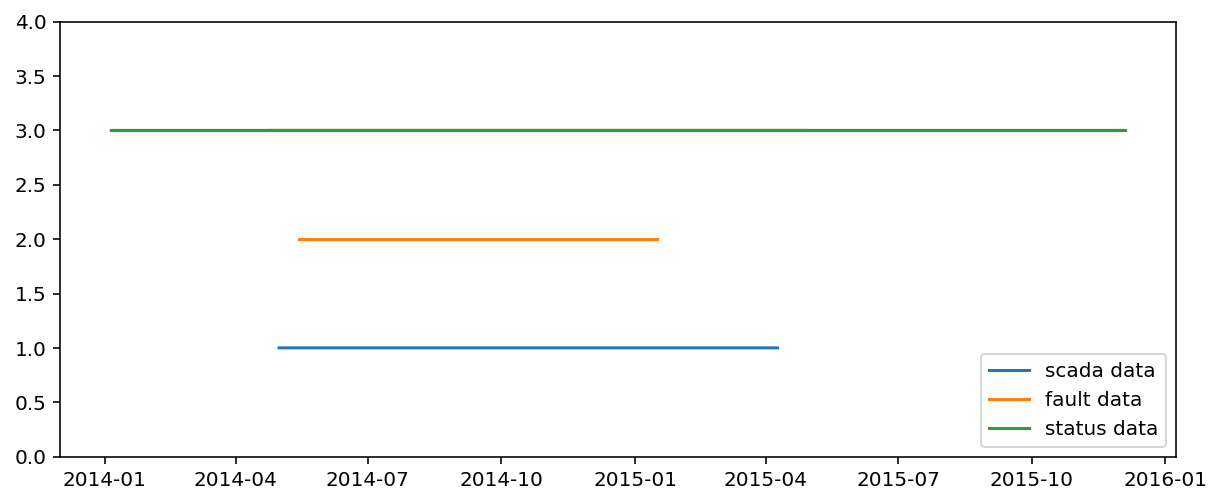

In [8]:
# Plot time span of all data
t_scada = scada_df.DateTime
t_fault = fault_df.DateTime
t_status = status_df.DateTime

plt.figure(figsize=(10,4))
plt.plot(t_scada, np.full(len(scada_df), 1), label='scada data')
plt.plot(t_fault, np.full(len(fault_df), 2), label='fault data')
plt.plot(t_status, np.full(len(status_df), 3), label='status data')
plt.legend(loc='lower right')
plt.ylim(0,4)

The number of wind turbine faults significantly increases on October 2014.

<AxesSubplot:xlabel='DateTime'>

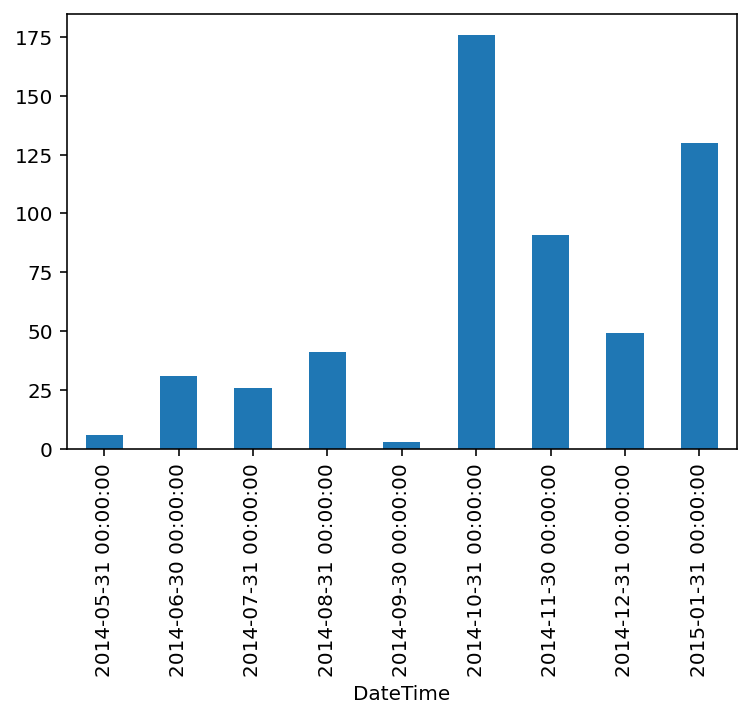

In [12]:
# Plot of number of faults on monthly resampled data
fault_df.resample('M', on='DateTime').Fault.count().plot.bar()

In [13]:
fault_df.resample('M', on='DateTime').Fault.value_counts()

DateTime    Fault
2014-05-31  GF        6
2014-06-30  AF       15
            MF       14
            FF        2
2014-07-31  AF       10
            EF        8
            FF        6
            MF        2
2014-08-31  AF       28
            EF        7
            FF        6
2014-09-30  AF        3
2014-10-31  EF       93
            FF       68
            GF       11
            MF        4
2014-11-30  EF       66
            FF       25
2014-12-31  FF       49
2015-01-31  FF       98
            GF       26
            AF        6
Name: Fault, dtype: int64

Let's plot the faults grouped by its fault modes. There are lots of EF events in October and November 2014, and lots of FF events from October 2014 - January 2015.

In [51]:
def line_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    if month == 'Jan':
        month += f'\n{label.year}'
    return month

<AxesSubplot:title={'center':'Wind Turbine Faults'}, xlabel='DateTime', ylabel='Fault Counts'>

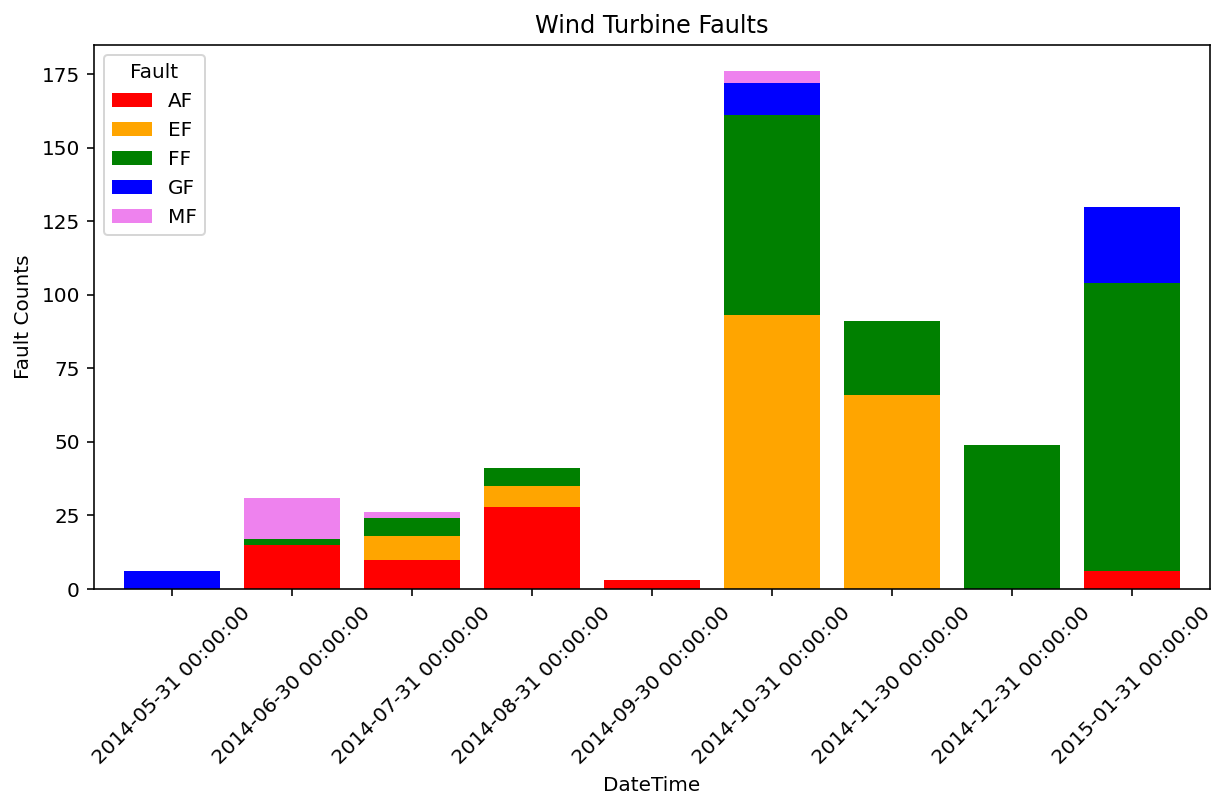

In [54]:
c = ['red', 'orange', 'green', 'blue', 'violet']
fault_df.resample('M', on='DateTime').Fault.value_counts().unstack().plot.bar(stacked=True, width=0.8, figsize=(10,5), color=c, rot=45,
                                                                              title='Wind Turbine Faults', ylabel='Fault Counts')

# 3. Combine SCADA and faults data

We combine SCADA and fault data to pair each measurements with associated faults.

<AxesSubplot:>

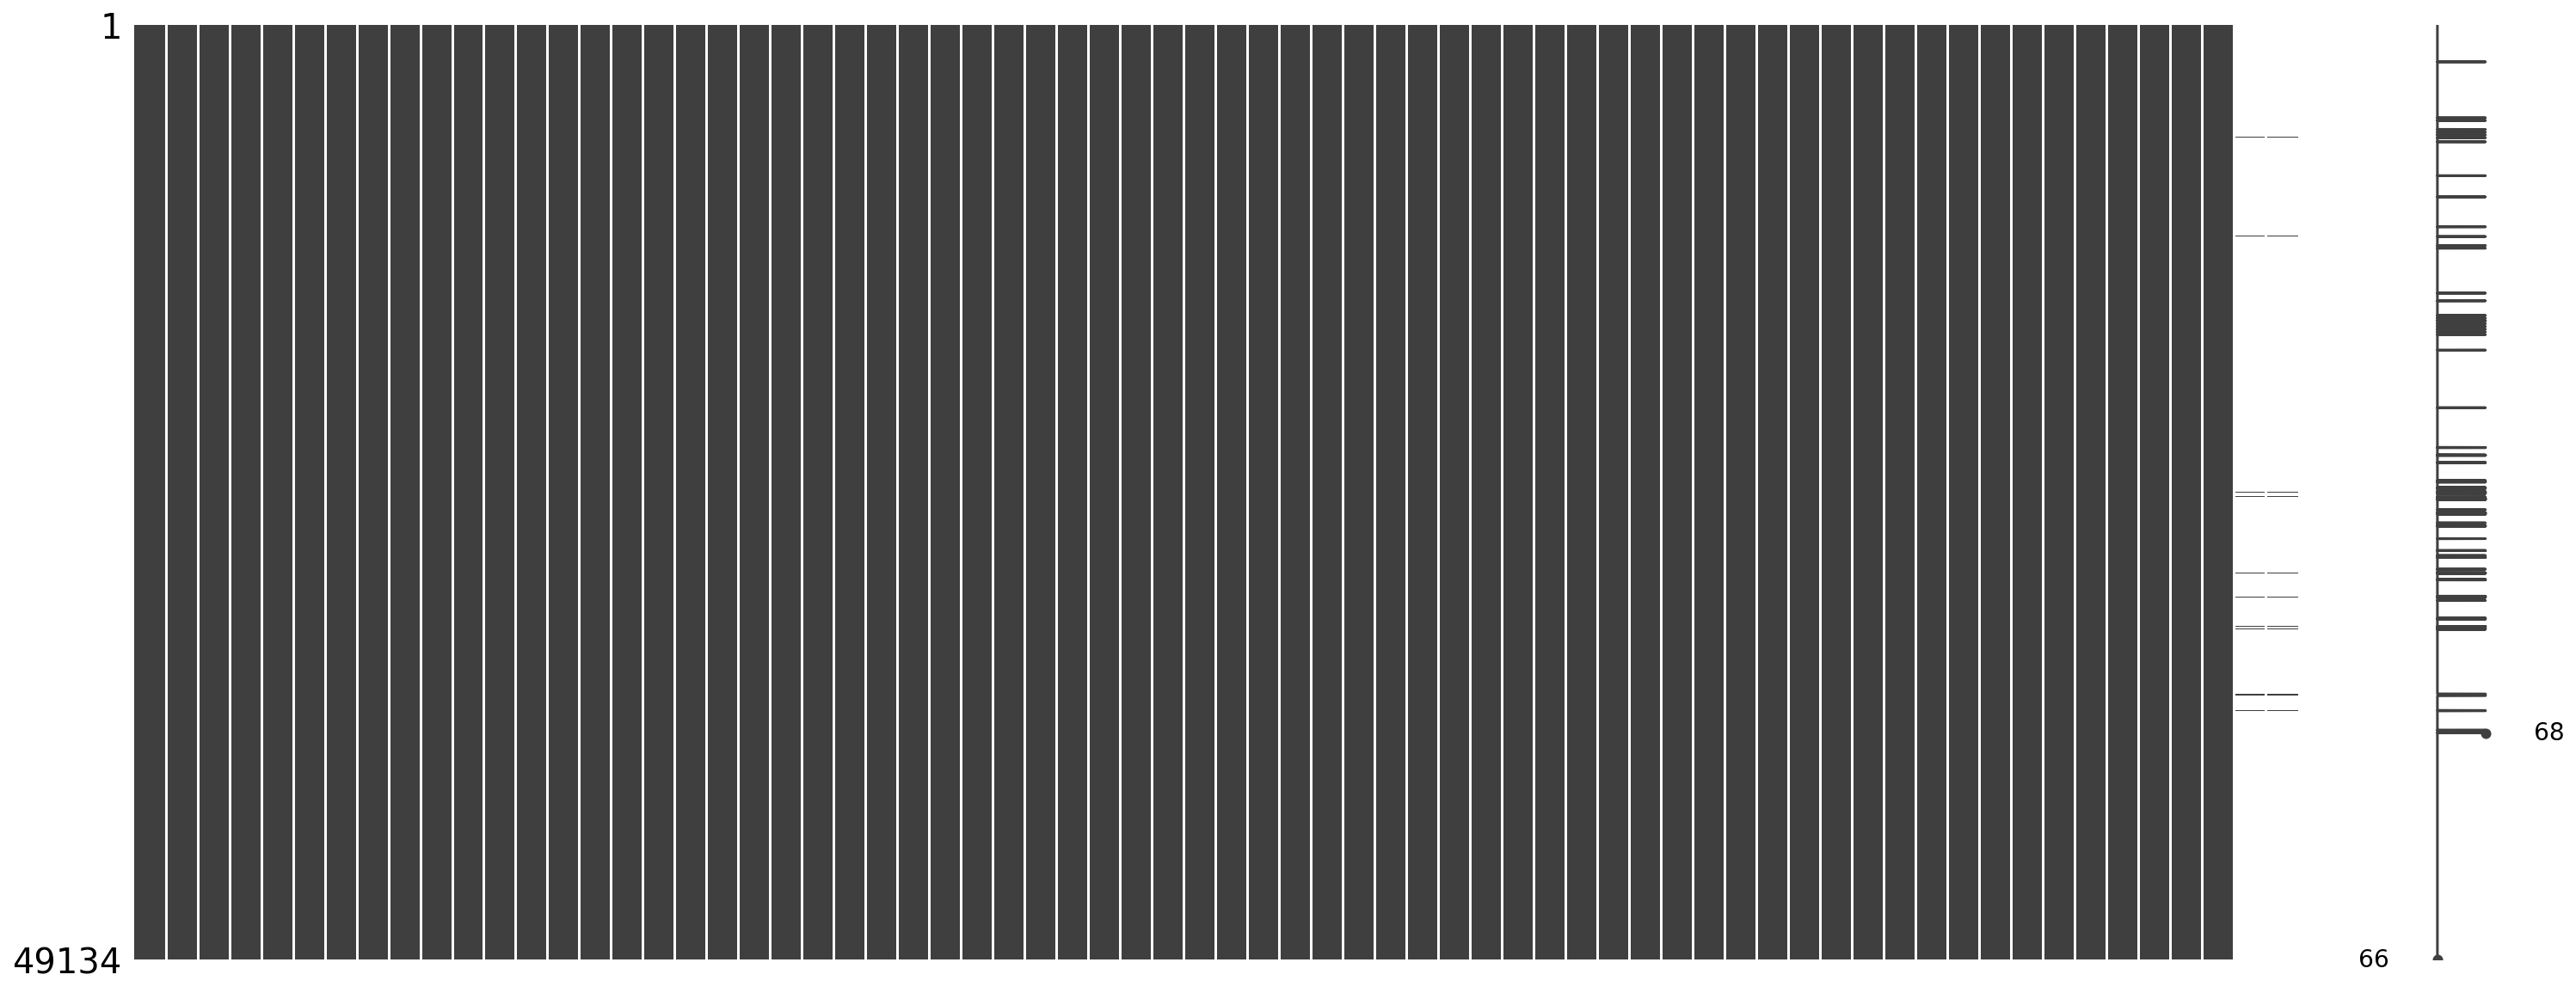

In [15]:
# Combine scada and fault data
df_combine = scada_df.merge(fault_df, on='Time', how='outer')
msno.matrix(df_combine)

There are lots of NaNs, or unmatched SCADA timestamps with fault timestamps, simply because there are no faults happen at certain time. For these NaNs, we will replace with "NF".

**NF is No Fault (normal condition)**

In [16]:
# Replace records that has no fault label (NaN) as 'NF' (no fault)
df_combine['Fault'] = df_combine['Fault'].replace(np.nan, 'NF')

df_combine

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
0,2014-05-01 00:00:00,1398920448,0,6.9,9.4,2.9,0.00,0.02,0.00,0,...,25,12,14,24,34,2501,25.272728,1.103713,NaT,NF
1,2014-05-01 00:09:00,1398920960,0,5.3,8.9,1.6,0.00,0.01,0.00,0,...,25,12,14,24,34,2501,25.272728,1.103713,NaT,NF
2,2014-05-01 00:20:00,1398921600,0,5.0,9.5,1.4,0.00,0.04,0.00,0,...,25,12,14,24,34,2501,25.272728,1.103713,NaT,NF
3,2014-05-01 00:30:00,1398922240,0,4.4,8.3,1.3,0.00,0.08,0.00,0,...,25,12,14,24,34,2501,25.272728,1.103713,NaT,NF
4,2014-05-01 00:39:00,1398922752,0,5.7,9.7,1.2,0.00,0.05,0.00,0,...,25,12,14,23,34,2501,25.272728,1.103713,NaT,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49129,2015-04-08 23:20:00,1428553216,0,3.9,5.5,2.2,6.75,7.40,6.01,147,...,28,9,17,27,35,3050,24.454546,3.474583,NaT,NF
49130,2015-04-08 23:30:00,1428553856,0,3.9,5.6,2.9,6.64,7.06,6.33,128,...,28,9,17,27,35,3050,24.454546,3.445683,NaT,NF
49131,2015-04-08 23:39:00,1428554368,0,4.2,6.7,2.6,7.18,8.83,6.22,163,...,28,9,18,27,34,3050,24.363636,3.413876,NaT,NF
49132,2015-04-08 23:50:00,1428555008,0,4.1,6.6,2.7,7.02,7.94,6.20,160,...,28,9,17,27,34,3050,24.000000,3.376389,NaT,NF


# 4. Exploratory Data Analysis

Print the averages of SCADA values grouped by fault modes.

In [17]:
# Suppress scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Groupby fault and take average
df_summary = df_combine.groupby('Fault').mean().T
df_summary.tail(20)

Fault,AF,EF,FF,GF,MF,NF
Blade C temp.,166.032,165.925,166.236,166.512,166.050,165.640
Rotor temp. 1,55.565,100.368,66.071,34.140,52.300,52.517
Rotor temp. 2,55.677,99.920,65.925,34.860,52.500,52.614
Stator temp. 1,68.903,101.592,70.425,42.837,66.350,60.702
Stator temp. 2,68.323,100.454,69.720,42.465,65.850,60.204
Nacelle ambient temp. 1,15.629,14.500,11.016,12.116,14.800,12.515
Nacelle ambient temp. 2,15.629,14.299,10.917,11.930,14.650,12.435
Nacelle temp.,19.290,17.368,14.051,14.093,17.850,16.339
Nacelle cabinet temp.,22.919,20.736,17.831,19.395,21.000,19.852
Main carrier temp.,20.548,19.632,15.866,13.279,19.100,16.551


Seeing the averages above, we could identify the anomalous behavior of Fault Modes:

* WF has lower ava, min, max active reactive power than No Fault (NF)
* EF has higher ava, min, max active reactive power than No Fault (NF)
* GF has ZERO ava, min, max active reactive power
* FF and MF have higher nacelle cable twisting than NF
* AF and GF have negative nacelle cable twisting
* AF and MF have lower production
* All faults have higher blade angle, the highest is FF
* GF in general has the lowest temperature in ALL components (cabinet temp, T spinner, T front bearing, ..., T transformer)
* While other faults (FF, AF, MF, EF) have higher temperature
* EF temperature is highest in cabinet, pitch, rotor, stator, ambient, control, tower, and transformer
* AF temperature is highest in spinner, front bearing, rare bearing, nacelle, main carrier, rectifier, yaw, and fan inverter

The boxplots of temperatures (at spinner, bearing, nacelle, and fan inverter) shows that during GF, the temperatures are anomalously lower than normal condition. However, temperatures are higher than normal during AF and EF.

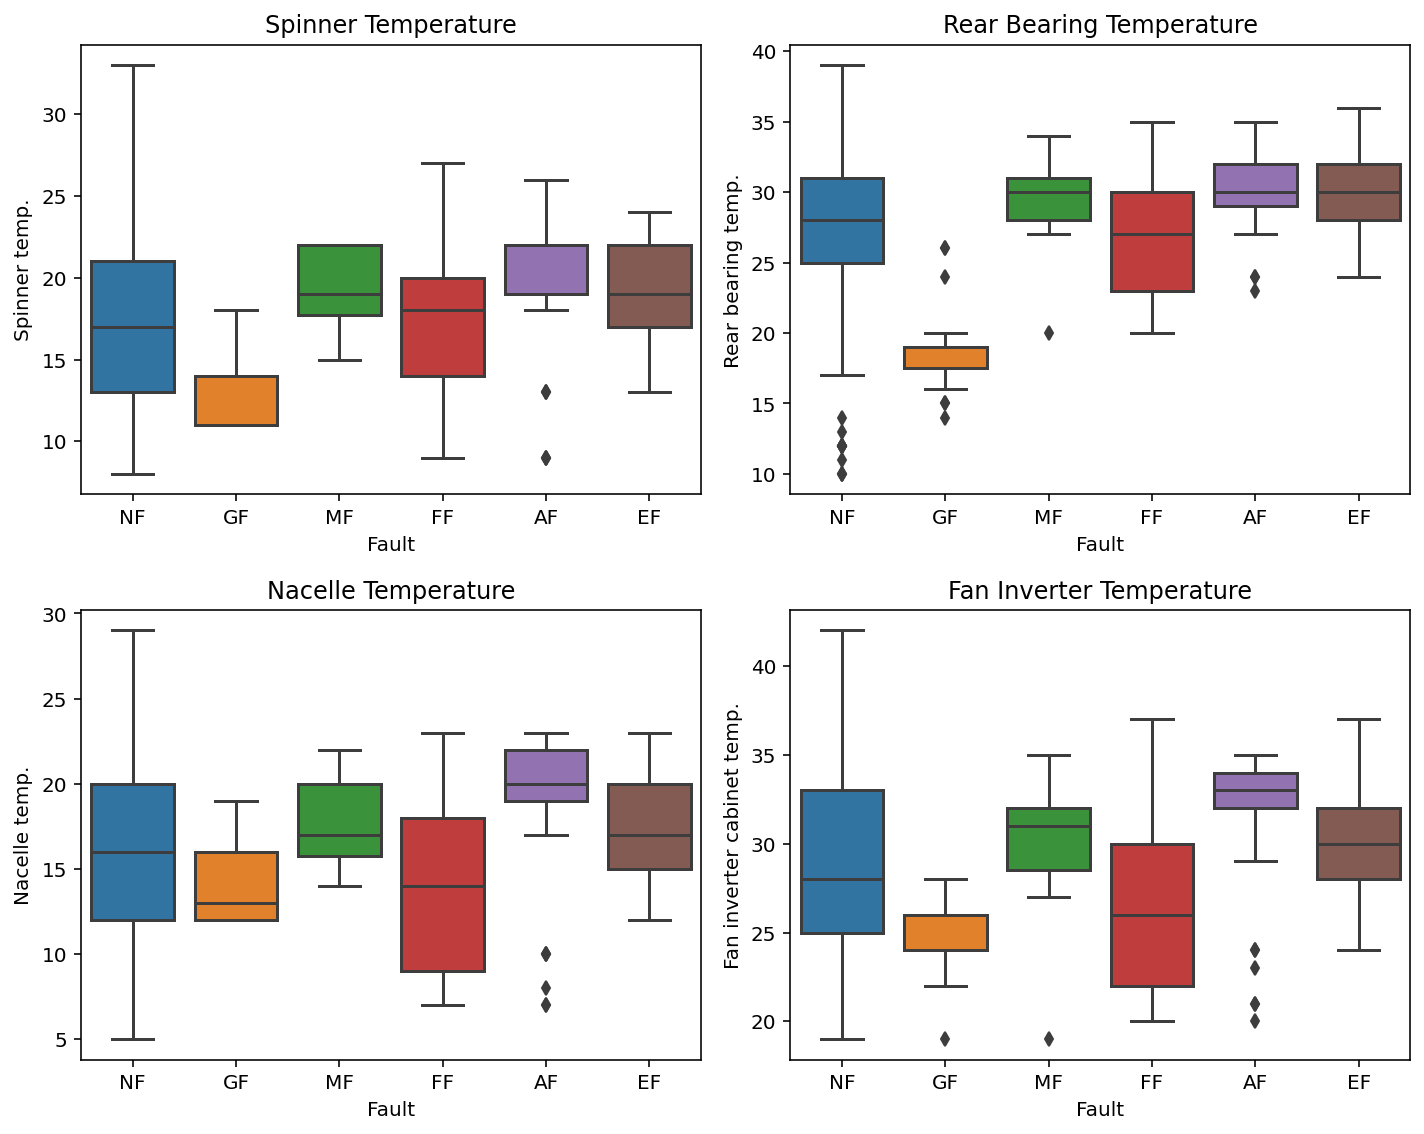

In [50]:
# Boxplots of temperature
f, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,8))

sns.boxplot(x='Fault', y='Spinner temp.', data=df_combine, ax=axes[0][0])
axes[0][0].set_title('Spinner Temperature')
sns.boxplot(x='Fault', y='Rear bearing temp.', data=df_combine, ax=axes[0][1])
axes[0][1].set_title('Rear Bearing Temperature')
sns.boxplot(x='Fault', y='Nacelle temp.', data=df_combine, ax=axes[1][0])
axes[1][0].set_title('Nacelle Temperature')
sns.boxplot(x='Fault', y='Fan inverter cabinet temp.', data=df_combine, ax=axes[1][1])
axes[1][1].set_title('Fan Inverter Temperature')

plt.tight_layout()

Boxplot of reactive power (power from the generator?) shows the power during EF is anomalously high, while the power during MF is lower than normal condition. 

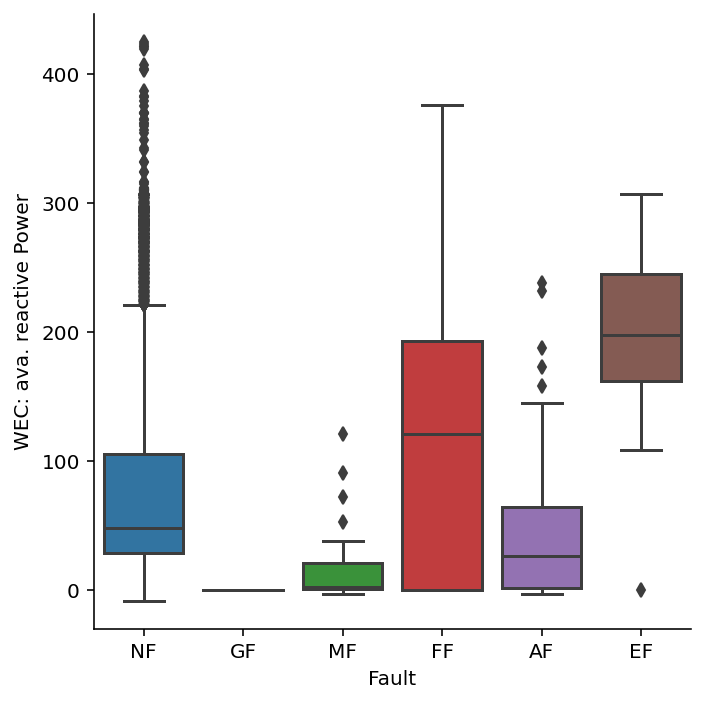

In [19]:
sns.catplot(data=df_combine, x='Fault', y='WEC: ava. reactive Power', kind='box')

The boxplot of nacelle position and cable twisting shows that during AF, nacelle position is negative (up to -500) while during MF, FF, and EF, nacelle position is positive (up to +500).

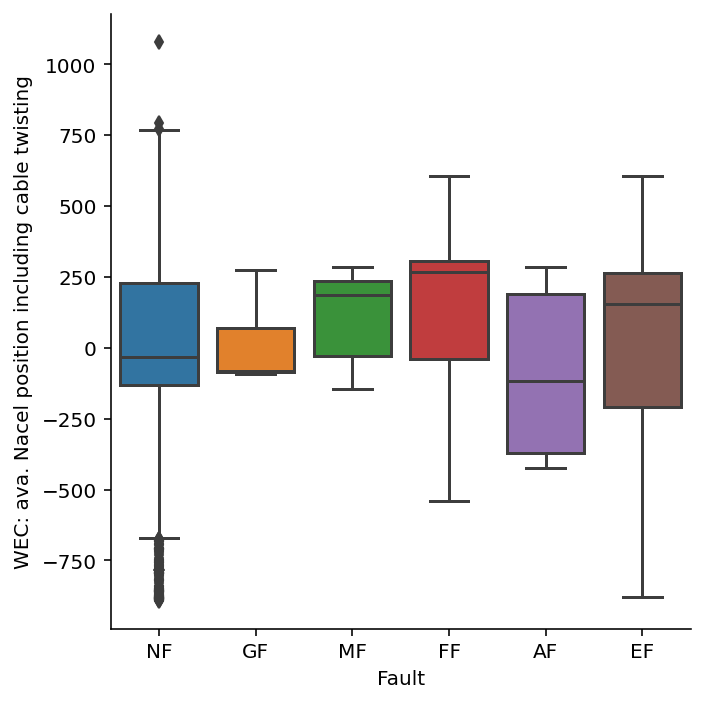

In [20]:
sns.catplot(data=df_combine, x='Fault', y='WEC: ava. Nacel position including cable twisting', kind='box')

The boxplot of operating hours shows that during MF and AF, the operating hours are shorter than normal condition. However, during FF, the operating hours are longer than normally are.

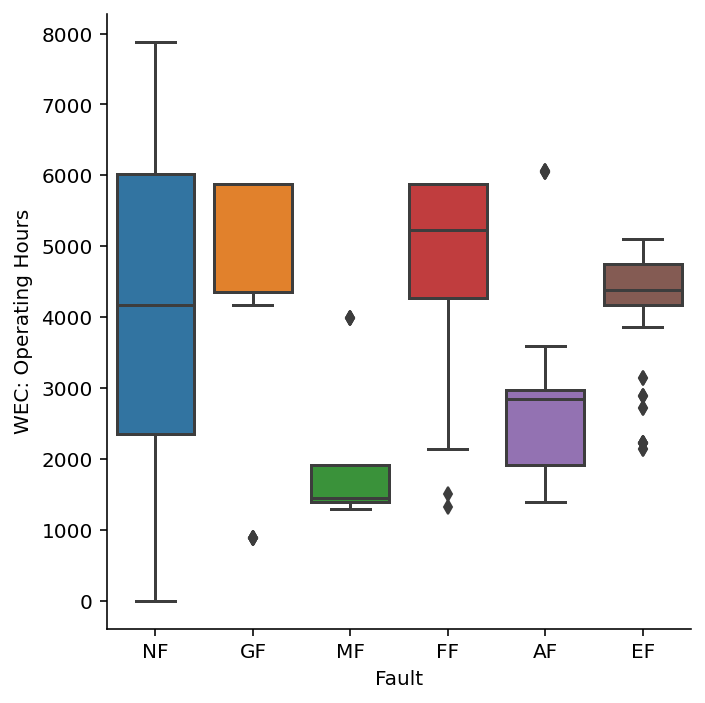

In [21]:
sns.catplot(data=df_combine, x='Fault', y='WEC: Operating Hours', kind='box')

# 5. Data preparation for ML

There are far more records of NF (normal condition) than faulty records - imbalanced dataset. We will sample the No Fault dataframe and pick only 300 records. 

In [22]:
df_combine.Fault.value_counts()

NF    48581
FF      254
EF      174
AF       62
GF       43
MF       20
Name: Fault, dtype: int64

In [23]:
# Pick 300 samples of NF (No Fault) mode data
df_nf = df_combine[df_combine.Fault=='NF'].sample(300, random_state=42)

df_nf

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
7340,2014-06-21 19:29:00,1403396992,0,3.500,4.600,2.400,6.370,6.640,6.160,87,...,40,20,26,36,45,3050,34.273,3.228,NaT,NF
949,2014-05-07 16:39:00,1399498752,0,5.300,15.000,3.000,0.000,0.000,0.000,0,...,26,16,15,24,33,2501,24.455,0.934,NaT,NF
37369,2015-01-17 00:00:00,1421474432,0,9.200,10.800,8.100,13.480,13.950,12.920,2078,...,20,3,18,25,40,3050,19.091,1.446,NaT,NF
15200,2014-08-15 07:30:00,1408105856,0,7.200,9.600,5.000,10.450,11.620,9.700,998,...,30,21,30,37,48,3050,30.545,1.036,NaT,NF
42798,2015-02-23 22:30:00,1424752256,0,14.900,20.900,11.200,14.690,15.540,14.130,3060,...,22,6,28,39,67,3050,28.273,1.902,NaT,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6298,2014-06-14 13:50:00,1402771840,0,2.200,4.300,0.400,4.600,5.120,4.150,1,...,40,24,25,35,45,3050,35.000,1.414,NaT,NF
22374,2014-10-04 01:38:00,1412404736,0,7.100,9.000,5.500,10.120,10.770,9.500,875,...,27,13,26,34,43,3050,28.091,1.136,NaT,NF
39742,2015-02-02 16:41:00,1422916864,0,2.100,2.600,1.700,5.050,5.320,4.940,6,...,21,4,8,17,27,3050,19.909,1.044,NaT,NF
34504,2014-12-28 02:40:00,1419756032,0,7.800,9.500,5.200,10.670,11.720,9.360,1138,...,22,4,19,27,38,3050,19.818,0.603,NaT,NF


In [24]:
# With fault mode data
df_f = df_combine[df_combine.Fault!='NF']

df_f

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
1945,2014-05-14 14:39:00,1400096384,0,5.700,7.400,4.100,9.980,10.230,9.720,0,...,27,17,26,35,34,2501,25.818,0.603,2014-05-14 14:39:44,GF
1946,2014-05-14 14:50:00,1400097024,0,6.400,8.600,2.700,4.120,10.710,0.700,0,...,27,17,26,35,34,2501,26.091,0.944,2014-05-14 14:50:24,GF
1947,2014-05-14 14:58:00,1400097536,0,5.600,7.500,4.000,9.990,10.200,9.800,0,...,27,17,26,35,34,2501,26.455,0.820,2014-05-14 14:58:56,GF
1948,2014-05-14 15:09:00,1400098176,0,5.300,6.600,4.100,9.980,10.170,9.790,0,...,27,18,26,35,34,2501,26.182,0.874,2014-05-14 15:09:36,GF
1949,2014-05-14 15:20:00,1400098816,0,5.100,7.200,3.800,9.990,10.170,9.800,0,...,28,18,26,35,34,2501,26.182,0.982,2014-05-14 15:20:16,GF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37075,2015-01-14 23:00:00,1421298048,0,13.500,22.000,7.700,14.690,15.190,13.830,2736,...,24,8,29,35,57,3050,25.909,1.814,2015-01-14 23:00:48,AF
37076,2015-01-14 23:09:00,1421298560,0,15.500,25.700,1.900,2.530,14.670,0.000,20,...,23,7,22,35,57,3050,28.182,1.834,2015-01-14 23:09:20,AF
37218,2015-01-15 22:50:00,1421383808,0,8.400,9.700,6.800,12.790,13.300,11.640,1667,...,21,5,21,28,42,3050,20.909,1.300,2015-01-15 22:50:08,AF
37219,2015-01-15 23:00:00,1421384448,0,8.100,9.800,6.000,11.710,13.270,9.990,1311,...,20,5,21,28,42,3050,20.909,1.300,2015-01-15 23:00:48,AF


In [25]:
# Combine no fault and faulty dataframes
df_combine = pd.concat((df_nf, df_f), axis=0).reset_index(drop=True)

df_combine

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
0,2014-06-21 19:29:00,1403396992,0,3.500,4.600,2.400,6.370,6.640,6.160,87,...,40,20,26,36,45,3050,34.273,3.228,NaT,NF
1,2014-05-07 16:39:00,1399498752,0,5.300,15.000,3.000,0.000,0.000,0.000,0,...,26,16,15,24,33,2501,24.455,0.934,NaT,NF
2,2015-01-17 00:00:00,1421474432,0,9.200,10.800,8.100,13.480,13.950,12.920,2078,...,20,3,18,25,40,3050,19.091,1.446,NaT,NF
3,2014-08-15 07:30:00,1408105856,0,7.200,9.600,5.000,10.450,11.620,9.700,998,...,30,21,30,37,48,3050,30.545,1.036,NaT,NF
4,2015-02-23 22:30:00,1424752256,0,14.900,20.900,11.200,14.690,15.540,14.130,3060,...,22,6,28,39,67,3050,28.273,1.902,NaT,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,2015-01-14 23:00:00,1421298048,0,13.500,22.000,7.700,14.690,15.190,13.830,2736,...,24,8,29,35,57,3050,25.909,1.814,2015-01-14 23:00:48,AF
849,2015-01-14 23:09:00,1421298560,0,15.500,25.700,1.900,2.530,14.670,0.000,20,...,23,7,22,35,57,3050,28.182,1.834,2015-01-14 23:09:20,AF
850,2015-01-15 22:50:00,1421383808,0,8.400,9.700,6.800,12.790,13.300,11.640,1667,...,21,5,21,28,42,3050,20.909,1.300,2015-01-15 22:50:08,AF
851,2015-01-15 23:00:00,1421384448,0,8.100,9.800,6.000,11.710,13.270,9.990,1311,...,20,5,21,28,42,3050,20.909,1.300,2015-01-15 23:00:48,AF


Preparing for the training dataset, we **drop irrelevant features**. First we drop datetime, time, and error columns. Next, features that "de facto" are output of wind turbine, such as power from wind, operating hours, and kWh production, are dropped. Also, climatic variable such as wind speed are not useful.

In [26]:
# Drop irrelevant features
train_df = df_combine.drop(columns=['DateTime_x', 'Time', 'Error', 'WEC: ava. windspeed', 
                                    'WEC: ava. available P from wind',
                                    'WEC: ava. available P technical reasons',
                                    'WEC: ava. Available P force majeure reasons',
                                    'WEC: ava. Available P force external reasons',
                                    'WEC: max. windspeed', 'WEC: min. windspeed', 
                                    'WEC: Operating Hours', 'WEC: Production kWh',
                                    'WEC: Production minutes', 'DateTime_y'])

train_df

,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,WEC: ava. Nacel position including cable twisting,WEC: ava. reactive Power,WEC: max. reactive Power,WEC: min. reactive Power,...,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,Fault
0,6.370,6.640,6.160,87,123,65,171,32,32,32,...,36,40,20,26,36,45,3050,34.273,3.228,NF
1,0.000,0.000,0.000,0,0,0,-52,0,0,0,...,22,26,16,15,24,33,2501,24.455,0.934,NF
2,13.480,13.950,12.920,2078,2533,1696,-66,173,204,152,...,16,20,3,18,25,40,3050,19.091,1.446,NF
3,10.450,11.620,9.700,998,1491,710,-376,64,79,55,...,24,30,21,30,37,48,3050,30.545,1.036,NF
4,14.690,15.540,14.130,3060,3114,2994,-68,296,299,294,...,19,22,6,28,39,67,3050,28.273,1.902,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,14.690,15.190,13.830,2736,2798,2417,-78,238,243,224,...,21,24,8,29,35,57,3050,25.909,1.814,AF
849,2.530,14.670,0.000,20,2746,0,-76,4,241,0,...,21,23,7,22,35,57,3050,28.182,1.834,AF
850,12.790,13.300,11.640,1667,1914,1259,-66,145,170,119,...,17,21,5,21,28,42,3050,20.909,1.300,AF
851,11.710,13.270,9.990,1311,1945,781,-53,111,155,77,...,16,20,5,21,28,42,3050,20.909,1.300,AF


<AxesSubplot:title={'center':'Fault Modes'}, ylabel='Fault'>

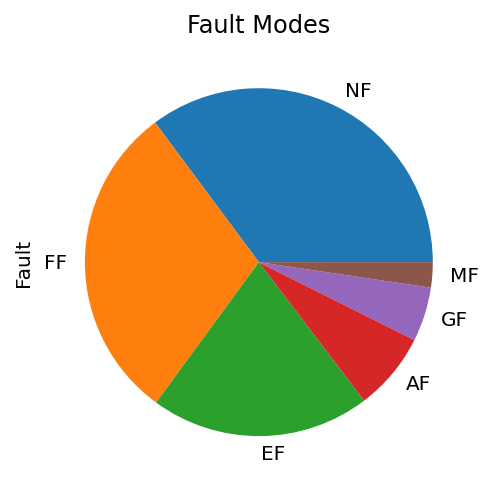

In [27]:
# Imbalanced fault modes
train_df.Fault.value_counts().plot.pie(title='Fault Modes')

# 6. Machine learning - fault modes classification

In [28]:
# Feature and target
X = train_df.iloc[:,:-1]
y = train_df.iloc[:,-1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Make pipeline of SMOTE, scaling, and classifier
pipe = make_pipeline(SMOTE(), StandardScaler(), LGBMClassifier(random_state=42))

# Define multiple scoring metrics
scoring = {
    'acc': 'accuracy',
    'prec_macro': 'precision_macro',
    'rec_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

# Stratified K-Fold 
stratkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Return a dictionary of all scorings
cv_scores = cross_validate(pipe, X_train, y_train, cv=stratkfold, scoring=scoring)

In [29]:
# Print scoring results from dictionary
for metric_name, metric_value in cv_scores.items():
    mean = np.mean(metric_value)
    print(f'{metric_name}: {np.round(metric_value, 4)}, Mean: {np.round(mean, 4)}')

fit_time: [1.0092 0.9177 1.6028 1.1511 1.2796], Mean: 1.1921
score_time: [0.0105 0.0106 0.012  0.0123 0.0119], Mean: 0.0115
test_acc: [0.7167 0.725  0.6891 0.7227 0.7563], Mean: 0.7219
test_prec_macro: [0.6034 0.6559 0.6754 0.646  0.7284], Mean: 0.6618
test_rec_macro: [0.6179 0.6579 0.5998 0.6037 0.7341], Mean: 0.6427
test_f1_macro: [0.6087 0.6566 0.6259 0.6166 0.7267], Mean: 0.6469


**The precision, recall, and F1 score are 65%.**

In [30]:
# Fit pipeline to train set
pipe.fit(X_train, y_train)

# Predict on test set
y_pred = pipe.predict(X_test)

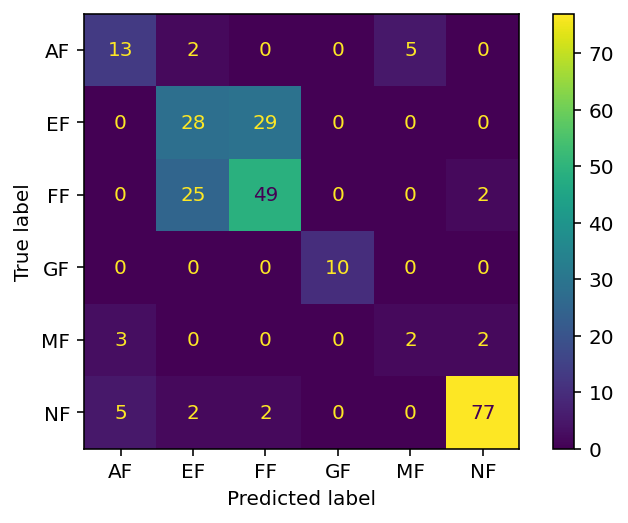

In [31]:
# Confusion matrix of test set
plot_confusion_matrix(pipe, X_test, y_test, values_format='.5g') 
plt.show()

We can see 2 problematic (false predicted) classes here are FF and EF. There are 30 EF predicted as FF, and 26 FF predicted as EF.

In [32]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          AF       0.62      0.65      0.63        20
          EF       0.49      0.49      0.49        57
          FF       0.61      0.64      0.63        76
          GF       1.00      1.00      1.00        10
          MF       0.29      0.29      0.29         7
          NF       0.95      0.90      0.92        86

    accuracy                           0.70       256
   macro avg       0.66      0.66      0.66       256
weighted avg       0.71      0.70      0.70       256



# 7. Hyperparameter tuning

From our previous LightGBM model, we achieved 65% precision, recall, and F1, however we find 2 problematic classes being falsely predicted. We will improve our model with hyperparameter tuning. We will do grid search over **4 hyperparameters** and optimize the **F1 score** as our metric.

In [45]:
# Define parameter search grid
param_grid = {'lgbmclassifier__n_estimators': [6, 8, 16, 24], 
              'lgbmclassifier__num_leaves': [4, 6, 8],
              'lgbmclassifier__reg_alpha' : [1, 1.5],
              'lgbmclassifier__reg_lambda': [1, 1.5],
              'lgbmclassifier__boosting_type': ['gbdt'] # Gradient Boosting Decision Tree
             }

# Grid search CV
grid = GridSearchCV(pipe, param_grid, verbose=1, cv=stratkfold, n_jobs=-1, scoring='f1_macro')

# Fit grid on train set
grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   10.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('standardscaler', StandardScaler()),
                                       ('lgbmclassifier',
                                        LGBMClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'lgbmclassifier__boosting_type': ['gbdt'],
                         'lgbmclassifier__n_estimators': [6, 8, 16, 24],
                         'lgbmclassifier__num_leaves': [4, 6, 8],
                         'lgbmclassifier__reg_alpha': [1, 1.5],
                         'lgbmclassifier__reg_lambda': [1, 1.5]},
             scoring='f1_macro', verbose=1)

We got **improvement to 70% F1-score** with the following tuned hyperparameters.

In [46]:
# Best model from tuning
print(grid.best_params_)
print(f'Average of Macro F1: {grid.best_score_}')

{'lgbmclassifier__boosting_type': 'gbdt', 'lgbmclassifier__n_estimators': 16, 'lgbmclassifier__num_leaves': 4, 'lgbmclassifier__reg_alpha': 1.5, 'lgbmclassifier__reg_lambda': 1}
Average of Macro F1: 0.7006205930085023


Using the tuned LightGBM model, we had successfully reduced the false classes i.e. from 30 to only 8 EF classes falsely predicted as FF. 

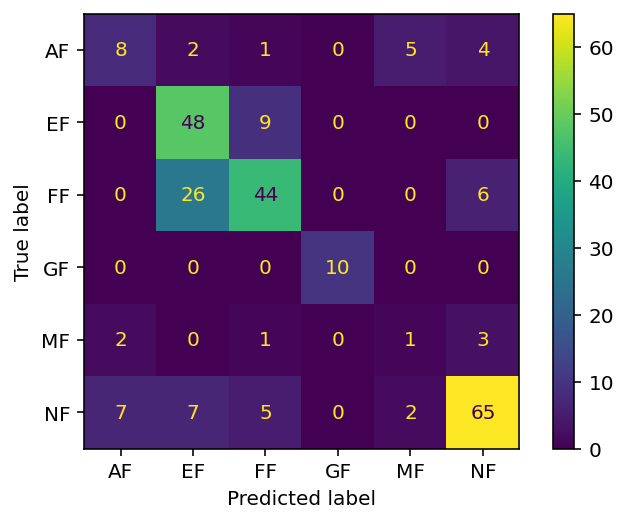

In [47]:
# Confusion matrix of test set
plot_confusion_matrix(grid, X_test, y_test, values_format='.5g') 
plt.show()

Comparing the present classification report to the previous report, we improved the F1-score of EF class from 46% to 69%, and small improvement of FF class from 62% to 68%.  

In [48]:
# Classification report
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          AF       0.47      0.40      0.43        20
          EF       0.58      0.84      0.69        57
          FF       0.73      0.58      0.65        76
          GF       1.00      1.00      1.00        10
          MF       0.12      0.14      0.13         7
          NF       0.83      0.76      0.79        86

    accuracy                           0.69       256
   macro avg       0.62      0.62      0.62       256
weighted avg       0.71      0.69      0.69       256



With this improvement, however, there remains some issues recommended for **future improvements of this work**:
* Eventhough there is improvement, 26 FF class still falsely predicted as EF
* Score of MF and AF are very low: 13% and 41%